<center><h1> PDE: Extension to Higher Dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist
import dolfin as fin

In [2]:
from mud.plot import make_2d_unit_mesh
from mud.util import std_from_equipment

In [3]:
presentation = False

In [4]:
from mud.funs import mud_problem
from mud_examples.plotting import plot_experiment_measurements
from mud_examples.helpers import fit_log_linear_regression
import matplotlib
if not presentation:
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    fdir = 'pde_2D'
else:
#     fdir = '../presentation/figures/pde-highd'
    fdir = 'pde_2D'
matplotlib.rcParams['font.size'] = 24
matplotlib.backend = 'Agg'

In [5]:
from poisson import poissonModel, poisson_sensor_model, eval_boundary_piecewise as pcwExpr
from poisson import eval_boundary, gamma_boundary_condition
import pickle

In [6]:
from mud_examples.models import generate_spatial_measurements as generate_sensors_pde
# from mud_examples.datasets import load_poisson

In [7]:
from mud_examples.helpers import experiment_measurements_index, extract_statistics_index

### Debugging: Implementation of Data-Driven Map

In [8]:
from scipy.stats import gaussian_kde as gkde

In [9]:
from mud.funs import wme

# Settings

In [10]:
prefix      = f'pde_2D/pde'
num_measure = 1000 # number of measurement (sensor) locations
fsize       = 36
num_trials  = 20   # realizations of synthetic data for numerical runs
tolerance   = 0.1 # precision of measurement equipment
sigma       = std_from_equipment(tolerance=tolerance, probability=0.99)
np.random.seed(21)
lam_true    = 3.0
input_dim   = 2
num_samples = 100
ftype       = 'png'

In [ ]:
load = False


In [12]:
import importlib
import poisson as p
importlib.reload(p)

<module 'poisson' from '/home/jovyan/work/mud-examples/scripts/poisson.py'>

In [ ]:
fname = p.make_reproducible_without_fenics(prefix, lam_true)

In [11]:
fname = 'pde_2D/pde_ref.pkl'

# From here, shouldn't need fenics.

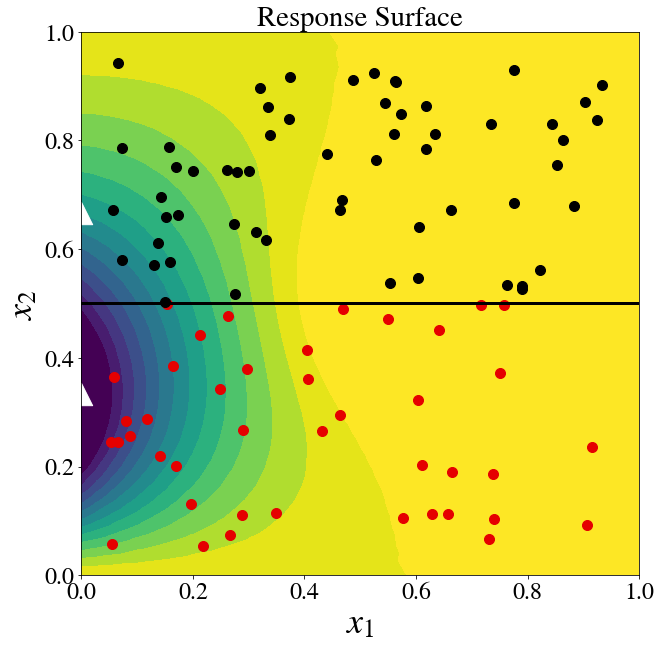

In [13]:
p.plot_without_fenics(fname, 100, mode='hor', num_qoi=2)

In [ ]:
# ref = pickle.load(open(fname, 'rb'))

In [ ]:
# ref.keys()

In [15]:
def load_poisson_from_disk(fname):
    ref = pickle.load(open(fname, 'rb'))
    lam = ref['lam']
    input_dim = lam.shape[1]
    domain = np.array([[-4,0]]*input_dim)
    qoi = ref['qoi']
    qoi_true = ref['data']
    lam_ref = ref['truth']
    u = ref['plot_u']
    g = ref['plot_g']
    sensors = ref['sensors']
    return domain, lam, qoi, qoi_true, lam_ref, u, g, sensors

In [16]:
domain, lam, qoi, qoi_ref, lam_ref, u, g, sensors = load_poisson_from_disk(fname)

In [ ]:
qoi.shape

In [17]:
P = p.pdeProblem(lam, qoi, lam_ref, qoi_ref, sensors, domain)

In [18]:
qoi_1d = P.qoi_1d()

In [ ]:
qoi_2d_hor = P.qoi_2d_hor()

In [ ]:
qoi_2d_hor?

In [ ]:
qoi_2d_hor(20, 0.05)

In [ ]:
qoi_1d??

In [ ]:
qoi_1d(20,0.05)

In [ ]:
def wrap(num_obs, sd):
    return mud_problem(lam, qoi, qoi_true, domain, sd=sd, num_obs=num_obs)

In [ ]:
m = wrap(100, 0.05)

In [ ]:
m.estimate()

In [ ]:
m._up.shape

In [ ]:
plt.tricontourf(lam[:,0], lam[:,1], m._up)

In [ ]:
q.shape

In [ ]:
from scipy.stats import gaussian_kde as gkde
from scipy.stats import distributions as dist

def ratio_dci_sing(qoi):
#     if qoi.ndim == 2:
#         qoi = qoi.ravel()
    kde = gkde(qoi.T)
    ratio_eval = dist.norm.pdf(qoi)/kde.pdf(qoi.T).ravel()
    return ratio_eval


In [ ]:
import mud.base as mb
importlib.reload(mb)

In [ ]:
num_obs = 100
data = qoi_true[0:num_obs] + np.random.randn(num_obs) * sd
q = wme(qoi[:, 0:num_obs], data, sd)
r = ratio_dci_sing(q)
print(r.shape)
plt.tricontourf(lam[:,0], lam[:,1], r)
plt.show()

d = mb.DensityProblem(lam, q, domain)
d.estimate()
plt.tricontourf(lam[:,0], lam[:,1], d._ob / d._pr)
plt.show()

# up = d._up
up = np.multiply(d._in, np.divide(d._ob, d._pr))
plt.tricontourf(lam[:,0], lam[:,1], up)
plt.show()

up = d._in
plt.tricontourf(lam[:,0], lam[:,1], up)
plt.show()

In [ ]:
d.domain

In [ ]:
lam[np.argmax(r),:]

In [ ]:
m.estimate()

In [ ]:
qoi_1d(20, 0.05)

In [ ]:
sd = std_from_equipment(0.1)

In [ ]:
d = mud_wrapper(100, sd)

In [ ]:
d.mud_point()

In [ ]:
measurements = [20, 40, 60, 80, 100]

In [ ]:
a = P.qoi_1d()
a

In [ ]:
a(100, 0.05)

In [ ]:
d = p.make_mud_wrapper(domain, lam, qoi, qoi_true)(100,0.05)

In [ ]:
d.mud_point()

In [23]:
from mud_examples.helpers import experiment_measurements

measurements = [20, 40, 60, 80, 100]


# SCALAR
experiments_sing, solutions_sing = experiment_measurements(num_measurements=measurements,
                                     sd=sigma,
                                     num_trials=num_trials,
                                     seed=21,
                                     fun=qoi_1d)
# # VECTOR
# def mud_wrapper(num_obs, sd):
#     qois = split_qoi_by_indices(qoi_indices, qoi_ref, qoi,
#                                 noise=np.random.randn(num_obs)*sd, sigma=sd, max_index=num_obs)
#     r_mult = ratio_dci_mult(qois)
#     return r_mult

# experiments_mult, solutions_mult = experiment_measurements_index(num_measurements=measurements,
#                                      sd=sigma,
#                                      num_trials=num_trials,
#                                      seed=21,
#                                      fun=mud_wrapper)

# del mud_wrapper

# Initial

In [24]:
closest_fit_index_in = np.argmin(np.linalg.norm(lam - np.array(lam_ref), axis=1))
closest_fit_index_out = np.argmin(np.linalg.norm(qoi - np.array(qoi_ref), axis=1))

In [25]:
def plot_samples(lam, qoi, qoi_ref, sols=None, num=20, save=False):
    closest_fit_index_out = np.argmin(np.linalg.norm(qoi - np.array(qoi_ref), axis=1))
    g_projected = list(lam[closest_fit_index_out, :])
    plt.figure(figsize=(10,10))

    g_mesh, g_plot = g
    intervals = list(np.linspace(0, 1, input_dim+2)[1:-1])
    # fin.plot(u_plot, mesh=mesh, lw=5, c='k', label="$g$")
    plt.plot(g_mesh, g_plot, lw=5, c='k', label="$g$")
    plt.plot([0]+intervals+[1], [0]+g_projected+[0], lw=5, c='green', alpha=0.6, ls='--', label='$\hat{g}$', zorder=5)


    if sols is not None and sols.get(num, None) is not None:
        plot_lam = np.array(sols[num])
        plt.title('MUD Estimates for $Q_{1D}$,' + f' N={num}', fontsize=1.25*fsize)
    else:  # initial plot, first 100
        plot_lam = lam[0:100, :]
        plt.title('Samples from Initial Density', fontsize=1.25*fsize)

    for _lam in plot_lam:
        plt.plot([0]+intervals+[1], [0]+list(_lam)+[0], lw=1, c='purple', alpha=0.2)

    
    plt.xlabel("$x_2$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)



    # label min(g)
    # plt.axvline(2/7, alpha=0.4, ls=':')
    # plt.axhline(-lam_true, alpha=0.4, ls=':')
    plt.ylim(-4,0)
    plt.xlim(0,1)
    plt.legend()
    if save:
        _fname = f"{prefix}_in_{input_dim}D.{ftype}"
        plt.savefig(_fname, bbox_inches='tight')
#     plt.show()

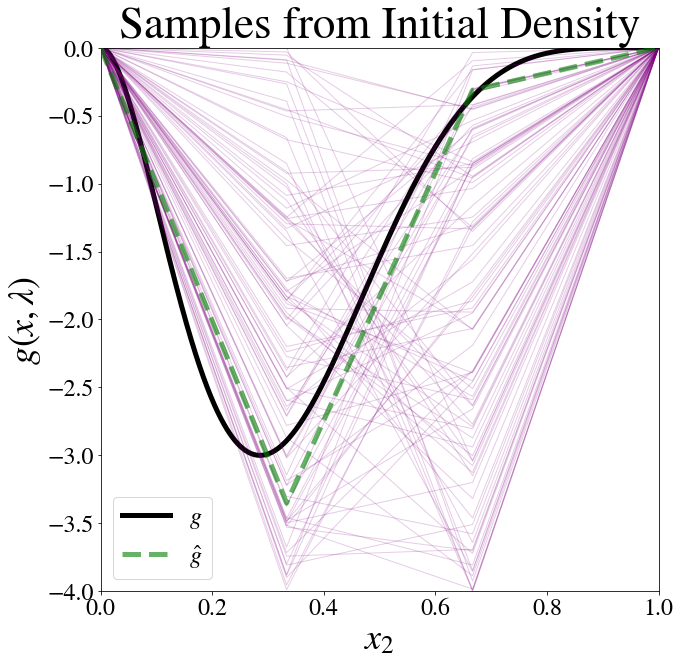

In [26]:
plot_samples(lam, qoi, qoi_ref, save=False)

In [ ]:
# _lam_sing = np.array(solutions_sing[num_plot_sensors])

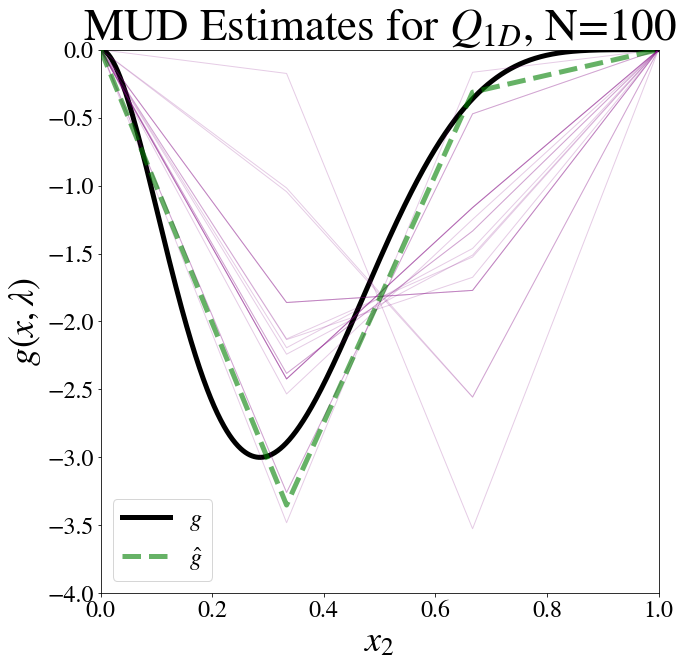

In [27]:
plot_samples(lam, qoi, qoi_ref, sols = solutions_sing, num=100, save=False)

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))

#     plt.subplot(111)
    plt.title('MUD Estimates for $Q_{1D}$,' + f' N={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_2$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)

    for _lam in solutions_sing[num_plot_sensors]: # trials
        plt.plot([0]+intervals+[1], [0]+list(_lam)+[0], lw=1, c='purple', alpha=0.2)


    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend(loc='lower left')
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_sing[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_ref[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#         plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_mud_{input_dim}-1_N{num_plot_sensors}.{ftype}"
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [ ]:
# assert 1 == 0

In [ ]:
# could not get this working
u = gamma_boundary_condition(lam_true)
mesh = fin.UnitIntervalMesh(100)
intervals, lam_ref = eval_boundary(u, 2)

# Define Sensors

In [ ]:
# %%time
if load:
    fname = f'./{prefix}_summary_{input_dim}.pkl'
    results = pickle.load(open(fname, 'rb'))
    solutions_sing, solutions_mult = results['sols']
    measurements = results['meas']
    noise, tolerance = results['noise']
    sigma = results['stdv']
    lam, qoi = results['sets']
    lam_ref, qoi_ref = results['true']
    sensors = results['sens']
    model_list = None
    
    pde = pdeProblem(lam, qoi, lam_ref, qoi_ref, sensors)
else:
    model_list = pickle.load(open(f'res{input_dim}u.pkl', 'rb'))
    sensors = generate_sensors_pde(num_measure)
    lam, qoi = load_poisson(sensors, model_list[0:num_samples], nx=36, ny=36)
    qoi_ref = poisson_sensor_model(sensors, gamma=lam_true, nx=36, ny=36)
    measurements = [20, 40, 60, 80, 100]
    # tolerances = [1E-1, 1E-2, 1E-3]
    print(f"Will run simulations for {measurements}")

In [ ]:
noise = sigma*np.random.randn(num_measure)

### Visualize

In [ ]:
p = poissonModel(gamma=lam_true, nx=36, ny=36)
V = p.function_space()

In [ ]:
svals = [p(xi,yi) for xi,yi in sensors]

In [ ]:
z = qoi_ref
x, y = sensors[:,0], sensors[:,1]
plt.tricontourf(x, y, z, levels=20, vmin=-0.5, vmax=0)
plt.scatter(x, y, c='r', s=0.5)
plt.show()

 ---

---

## Response Surface

$\tau$ was specified in the cells above using `tolerance`, take a look at your possible data and determine if it is reasonable before proceeding.

In [ ]:
# pn = poissonModel()  # defaults to gamma = 3
pn = poissonModel(gamma=lam_true)  # pass a scalar to get reference solution
v = np.array(pn.vector())
# v = p.compute_vertex_values()
# pn.vector()[:] = v + sigma*np.random.randn(len(v))

In [ ]:
m.cells()

In [ ]:
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Response Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
plt.scatter(sensors[0:100,0], sensors[0:100,1], s=100, c='k')
plt.show()

In [ ]:
w = fin.Expression(pcwExpr(u, input_dim, d=0), degree=2)
u_plot = fin.Expression(pcwExpr(u, 1000, d=0), degree=2)
domain = np.array([[-4,0]*input_dim]).reshape(-1,2)

## Best Case Scenario: Minimizing 2-Norms with Knowledge of Truth
minimizing norm of difference between "truth" and our samples, both input and output.

In [ ]:
# %%time
closest_fit_index_in = np.argmin(np.linalg.norm(lam - np.array(lam_ref), axis=1))
closest_fit_index_out = np.argmin(np.linalg.norm(qoi - np.array(qoi_ref), axis=1))

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
fin.plot(w, mesh=mesh, lw=5, c='k')
gt = list(lam[closest_fit_index_in, :])
plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='purple', alpha=1, label=f'Closest in Input: {closest_fit_index_in}')

projected_line = list(lam[closest_fit_index_out, :])
plt.plot([0]+intervals+[1], [0]+projected_line+[0], lw=5, c='green', alpha=1, label=f'Closest in Output: {closest_fit_index_out}')

plt.legend(fontsize=fsize*0.75)
plt.title(f'Parameter Space', fontsize=fsize*1.25)
plt.ylim(-4, 0)
plt.xlim(0, 1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)

plt.subplot(122)
_plot_num = max(measurements)
q = qoi[closest_fit_index_in,:]
plt.scatter(q[:_plot_num], qoi_ref[:_plot_num] + noise[:_plot_num], c='purple', s=100, alpha=0.4, label=f'Closest in Input: {closest_fit_index_in}')
q = qoi[closest_fit_index_out,:]
plt.scatter(q[:_plot_num], qoi_ref[:_plot_num] + noise[:_plot_num], c='green', s=100, alpha=0.4, label=f'Closest in Output: {closest_fit_index_out}')

_a = np.linspace(min(qoi_ref),max(qoi_ref), 2)
plt.plot(_a,_a, c='k', lw=3)
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5, 0.2)
# plt.legend(fontsize=fsize)
plt.xlabel('Predicted Data', fontsize=fsize)
plt.ylabel('Collected Data', fontsize=fsize)
plt.title("Q-Q Plot", fontsize=fsize*1.25)

_fname = f"{prefix}_proj_{input_dim}D.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

---

In [ ]:
num_qoi = input_dim
# plot_qoi = [20, 100, 500, 1000][::-1]
plot_qoi = measurements[::-2]

colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']

In [ ]:
_intervals = np.array(intervals[1:]) + ( np.array(intervals[:-1]) - np.array(intervals[1:]) ) / 2

In [ ]:
qoi_indices     = band_qoi(sensors, num_qoi, axis=1)
qoi_indices_bad = band_qoi(sensors, num_qoi, axis=0)

In [ ]:
fdir = '/'.join(prefix.split('/')[:-1])
from mud_examples.helpers import check_dir
check_dir(fdir)

In [ ]:
# horizontal plot
plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axhline(_intervals[i], lw=3, c='k')
    _q = qoi_indices[i][qoi_indices[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim, intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors_{input_dim}D.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

# vertical plot
plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axvline(_intervals[i], lw=3, c='k')
    _q = qoi_indices_bad[i][qoi_indices_bad[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim,intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors-alt_{input_dim}D.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

# Geometry Study

In [ ]:
if input_dim == 2:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green'][::-1]
#     plot_qoi = [20, 100, 500, 1000][::-1]
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices, qoi_ref, qoi, noise, sigma, max_index=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Horizontal Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q_1$", fontsize=fsize)
    plt.ylabel("$q_2$", fontsize=fsize)
    
    plt.subplot(122)
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices_bad, qoi_ref, qoi, noise, sigma, max_index=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Vertical Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q^*_1$", fontsize=fsize)
    plt.ylabel("$q^*_2$", fontsize=fsize)

else:
    plt.figure(figsize=(20,20))
#     lim = 7.5/tolerance
    lim = 3/tolerance
    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i == _j:
                ax = axs[_i][_i]

                ax.annotate(f"$q{_i+1}$", (-lim/10,0), fontsize=fsize)
    #             ax.set_ylabel(f"$q{_i+1}$")
    #             ax.set_xlabel(f"$q{_i+1}$")
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)
    #             ax.set_xticks([])
    #             ax.set_yticks([])
            else:
                for idx, _first in enumerate(plot_qoi):
                    ax = axs[_i][_j]
                    qois = split_qoi_by_indices(qoi_indices, qoi_ref, qoi, noise, sigma, max_index=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    ax = axs[_j][_i]
                    qois = split_qoi_by_indices(qoi_indices_bad, qoi_ref, qoi, noise, sigma, max_index=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

_fname = f"{prefix}_geom_{input_dim}D.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()    

# POC: Solve Inverse Problem

### Single QoI

In [ ]:
# noise = np.random.randn(num_measure)*sigma
num_samps_ex_sol = 100

In [ ]:
%%time
X = qoi[:,0:num_samps_ex_sol]
data = qoi_ref[0:num_samps_ex_sol] + noise[0:num_samps_ex_sol]
newqoi = wme(X, data, sigma)
r_sing = ratio_dci_sing(newqoi)

In [ ]:
mud_idx = np.argmax(r_sing)
mud_fun = lam[mud_idx,:]
print(mud_idx)

### Multiple QoI

In [ ]:
num_qoi = 2

In [ ]:
qoi_indices = p.band_qoi(sensors, num_qoi, axis=1)

In [ ]:
%%time
qois = split_qoi_by_indices(qoi_indices, qoi_ref, qoi, noise, sigma, max_index=num_samps_ex_sol)
r_mult = ratio_dci_mult(qois)

In [ ]:
mud_idx_mult = np.argmax(r_mult)
mud_fun_mult = lam[mud_idx_mult,:]

In [ ]:
mud_idx_mult

## Compare Vector-Valued and Scalar Example Solutions

In [ ]:
plt.figure(figsize=(30,10))
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']
plt.subplot(131)
fin.plot(poissonModel(mud_fun, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Scalar-Valued)', fontsize=1.25*fsize)

plt.subplot(132)
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title('(Noisy) Response Surface', fontsize=1.25*fsize)
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axhline(_intervals[i], lw=3, c='k')
    _q = qoi_indices[i][qoi_indices[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim, intervals, s=400, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

plt.subplot(133)
fin.plot(poissonModel(mud_fun_mult, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Vector-Valued)', fontsize=1.25*fsize)

_fname = f"{prefix}_surf_exmud_{input_dim}D_m{num_samps_ex_sol}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(111)
fin.plot(u_plot, mesh=mesh, lw=5, c='k')
fin.plot(w, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')

# fin.plot(w, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5)
plt.scatter(intervals, lam_ref, marker='^', s=200, c='purple', zorder=10)
plt.title(f'Ex. MUD Solution, m={num_samps_ex_sol}', fontsize=1.25*fsize)

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun) + [0],
            alpha=0.5, c='r', lw=10, label=f'Scalar MUD, Sample {mud_idx}')

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun_mult) + [0],
            alpha=0.5, c='b', lw=10, label=f'Vector MUD, Sample {mud_idx_mult}')

plt.axvline(2/7, alpha=0.4, ls=':')
plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)
plt.legend(fontsize=fsize*0.6, loc='lower right')

# plt.subplot(122)
# _data = qoi_ref[:num_samps_ex_sol] + noise[:num_samps_ex_sol]
# plt.scatter(qoi[mud_idx,:num_samps_ex_sol], _data, c='r', s=100, alpha=0.4, label=f'Scalar MUD, Sample {mud_idx}')
# plt.scatter(qoi[mud_idx_mult,:num_samps_ex_sol], _data, c='b', s=100, alpha=0.4, label=f'Vector MUD, Sample {mud_idx_mult}')

# _a = np.linspace(min(qoi_ref) ,max(qoi_ref), 2)
# plt.plot(_a,_a, c='k', lw=3)
# plt.xlim(-0.5, 0.2)
# plt.ylim(-0.5, 0.2)
# plt.xlabel('Predicted Data', fontsize=fsize)
# plt.ylabel('Collected Data', fontsize=fsize)
# plt.title("Q-Q Plot", fontsize=fsize*1.25)
# plt.legend()


_fname = f"{prefix}_comp_exmud_{input_dim}D_m{num_samps_ex_sol}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [ ]:
print(lam_ref)

In [ ]:
labels = ['Scalar QoI', 'Vector QoI']
plot_top = 1000
thresh = lam.shape[0]**-1
# thresh = 1E-16
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']

if input_dim == 2:
    for _i in range(input_dim):
        for _j in range(_i+1, input_dim):
            for idx, ratio_eval in enumerate([r_sing, r_mult]):
                _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
#                 plt.scatter(lam[_m[101:5000], _i], lam[_m[101:5000], _j], c='orange', marker='^', alpha=0.2)
#                 plt.scatter(lam[_m[plot_top+1:1000], _i], lam[_m[plot_top+1:1000], _j], c='orange', marker='^', alpha=0.2)
                plt.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[idx], label= labels[idx] + ' (Total %d)'%len(_m), s=50)
            plt.xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
            plt.ylabel(f"$\lambda_{_j+1}$", fontsize=fsize)
            plt.ylim(-4,0)
            plt.xlim(-4,0)
            plt.scatter(lam_ref[_i], lam_ref[_j], c='k', s=500, alpha=0.5, label='Interpolant', zorder=-10)
            plt.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=500, alpha=0.8, label='Projection', zorder=15)
            plt.legend()
            plt.title(f"Samples (m = {num_samps_ex_sol}) with\nRelative Ratio > {thresh:1.1E}", fontsize=fsize)

else:

    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i != _j:
                for idx, ratio_eval in enumerate([r_sing, r_mult]):
                    ax = axs[_j][_i] if not idx else axs[_i][_j]
                    _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
                    ax.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[2+idx], label= str(len(_m)) + ' ' + labels[idx], s=10)


    #                 ax.set_xlabel(f"$\lambda_{_i+1}$")
    #                 ax.set_ylabel(f"$\lambda_{_j+1}$")
                    ax.set_ylim(-4,0)
                    ax.set_xlim(-4,0)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.scatter(lam_ref[_i], lam_ref[_j], c='k', s=250, alpha=1, label='Interpolant', zorder=-10)
                    ax.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=400, alpha=0.5, label='Projection', zorder=-10)
    #                 ax.legend()
            else:
                ax = axs[_i][_i]
                ax.annotate(f"$\lambda_{_i+1}$", (-0.6,0.5), fontsize=fsize)
#                 ax.set_xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
#                 ax.set_ylabel(f"$\lambda_{_i+1}$", fontsize=fsize)

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlim(-1,0)


_fname = f"{prefix}_update_scatter_{input_dim}D_t{thresh:1.1E}".replace('.', '-') + f".{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

## Set Up Experiments

In [ ]:
%%time
if input_dim == 11:
    measurements = [60, 80, 100]

if not load:
    # SCALAR
    def mud_wrapper(num_obs, sd):
        newqoi = wme(X=qoi[:,0:num_obs], data=qoi_ref[0:num_obs] + np.random.randn(num_obs)*sd, sd=sd)
        r_sing = ratio_dci_sing(newqoi)
        return r_sing

    experiments_sing, solutions_sing = experiment_measurements_index(num_measurements=measurements,
                                         sd=sigma,
                                         num_trials=num_trials,
                                         seed=21,
                                         fun=mud_wrapper)
    # VECTOR
    def mud_wrapper(num_obs, sd):
        qois = split_qoi_by_indices(qoi_indices, qoi_ref, qoi,
                                    noise=np.random.randn(num_obs)*sd, sigma=sd, max_index=num_obs)
        r_mult = ratio_dci_mult(qois)
        return r_mult
    
    experiments_mult, solutions_mult = experiment_measurements_index(num_measurements=measurements,
                                         sd=sigma,
                                         num_trials=num_trials,
                                         seed=21,
                                         fun=mud_wrapper)
    
    del mud_wrapper

---

# The Story in Prediction Space

In [ ]:
if num_qoi == 1:
    solutions = solutions_sing
else:
    solutions = solutions_mult

In [ ]:
# if we have files available to load, do so
if model_list is not None:
    np.random.seed(21)
    num_draws = 3
    for idx in range(num_draws):
        i = np.random.randint(0,len(model_list))
        mudU = fin.Function(V, model_list[i][i]['u'])
        plt.subplot(int(f'{num_draws}{3}{1+3*idx}'))
        fin.plot(mudU, vmin=-0.5, vmax=0)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Rand#{idx}: {i}")
    # plt.show()

    num_plot_sensors = max(measurements)
    for idx in range(num_draws):
    #     _r = np.random.randint(0, num_trials)
        _r = idx
        i = solutions[num_plot_sensors][_r]
        mudU = fin.Function(V, model_list[i][i]['u'])
        plt.subplot(int(f'{num_draws}{3}{2+3*idx}'))
        fin.plot(mudU, vmin=-0.5, vmax=0)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"MUD#{idx}: {i}")

        q = qoi[i,:]
        plt.subplot(int(f'{num_draws}{3}{3+3*idx}'))
        plt.scatter(qoi_ref + noise, q, c='b', s=50, alpha=0.05)
        plt.plot(_a,_a, c='k', lw=3)
    #     plt.xlabel('True QoI (Noiseless)')
    #     plt.ylabel('Predicted Signal')
        plt.xticks([])
        plt.yticks([])
        plt.xlim(-0.5, 0.2)
        plt.ylim(-0.5, 0.2)
        plt.title(f"MUD#{idx}: {i}")

    plt.show()

    # p = poisson(3.0)
    # fin.plot(p, mesh=mesh, vmin=-0.5, vmax=0)
    # plt.title("True (Noiseless) Repsonse Surface")
    # plt.show()

# The Story in Parameter Space

In [ ]:
gt = list(lam[closest_fit_index_out, :])
plt.figure(figsize=(10,10))

# fin.plot(u_plot, mesh=mesh, lw=5, c='k', label="$g$")
plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label='$\hat{g}$', zorder=5)

# plt.scatter(intervals, lam_ref, marker='^', s=200, c='purple', zorder=10)
# plt.plot([0]+intervals+[1], [0]+projected_line+[0], lw=5, c='green', alpha=1, label="$Proj_{g}$")


for i in range(100):
    _lam= lam[i,:]
    plt.plot([0]+intervals+[1], [0]+list(_lam)+[0], lw=1, c='purple', alpha=0.2)
plt.title('Samples from Initial Density', fontsize=1.25*fsize)
plt.xlabel("$x_2$", fontsize=fsize)
plt.ylabel("$g(x, \lambda)$", fontsize=fsize)




# plt.axvline(2/7, alpha=0.4, ls=':')
# plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.legend()

_fname = f"{prefix}_in_{input_dim}D.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))
    
    plt.subplot(111)
    plt.title('MUD Estimates for $Q_{1D}$,' + f' N={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_2$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    for i in solutions_sing[num_plot_sensors]: # trials
        _lam = lam[i,:]
        plt.plot([0]+intervals+[1], [0]+list(_lam)+[0], lw=1, c='purple', alpha=0.2)
#     fin.plot(u_plot, mesh=mesh, lw=5, c='k', label="$g$")
    plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label='$\hat{g}$')

    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend(loc='lower left')
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_sing[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_ref[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#         plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_mud_{input_dim}-1_N{num_plot_sensors}.{ftype}"
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))
    
    plt.subplot(111)
    plt.title('MUD Estimates for $Q_{2D}$,' + f' N={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
#     plt.plot([0]+intervals+[1], [0]+ [w(i) for i in intervals] +[0], lw=5, c='k',label="Interpolant")
    for i in solutions_mult[num_plot_sensors]: # trials
        _lam = lam[i,:]
        plt.plot([0]+intervals+[1], [0]+list(_lam)+[0], lw=1, c='purple', alpha=0.2)
#     fin.plot(u_plot, mesh=mesh, lw=5, c='k', label="$g$")
    gt = list(lam[closest_fit_index_out, :])
    plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label='$\hat{g}$')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend(loc='lower left')
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_mult[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_ref[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#     plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_mud_{input_dim}-{num_qoi}_N{num_plot_sensors}.{ftype}"
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [ ]:
if not load:
    print("Saving")
    fname = f'{prefix}_summary_{input_dim}.pkl'
    pickle.dump({'sets': (lam, qoi), 'sols': (solutions_sing, solutions_mult), 'meas': measurements, 'noise': (noise, tolerance), 'stdv': sigma, 'true': (lam_ref, qoi_ref), 'sens': sensors }, open(fname, 'wb'))

## Bad QoI - split in vertical
## (TODO generalize plotting code)

In [ ]:
# VECTOR
def mud_wrapper(num_obs, sd):
    qois = split_qoi_by_indices(qoi_indices_bad, qoi_ref, qoi,
                                noise=np.random.randn(num_obs)*sd, sigma=sd, max_index=num_obs)
    r_mult = ratio_dci_mult(qois)
    return r_mult

experiments_mult_bad, solutions_mult_bad = experiment_measurements_index(num_measurements=measurements,
                                     sd=sigma,
                                     num_trials=num_trials,
                                     seed=21,
                                     fun=mud_wrapper)

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))
    
    plt.subplot(111)
    plt.title('MUD Estimates for $Q_{2D}^\prime$,' + f' S={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    plt.plot([0]+intervals+[1], [0]+ [w(i) for i in intervals] +[0], lw=5, c='k',label="Interpolant")
    for i in solutions_mult_bad[num_plot_sensors]: # trials
        gt = lam[i,:]
        plt.plot([0]+intervals+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
    gt = list(lam[closest_fit_index_out, :])
    plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label=f'Closest in Output: {closest_fit_index_out}')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend(loc='lower left')
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_mult[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_ref[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#     plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_mud-alt_{input_dim}-{num_qoi}_N{num_plot_sensors}.{ftype}"
#     plt.savefig(_fname, bbox_inches='tight')
    plt.show()

---